# Assignement for course ML2

Students: Tristan STAMPFLER and Thomas CARTA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("data/CreditTraining.csv")

## 1) Exploration of the dataset

Preliminary exploration of the dataset is necessary to determine which field we can use.

In [3]:
df.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,07/08/1977,13/02/2012,NP_Client,University,Married,3.0,1,36,1.0,C,14/02/2012,Sales,Owned,1,NaN,B
1,573,0,Existing Client,13/06/1974,04/02/2009,P_Client,University,Married,0.0,12,18,2.0,C,30/06/2011,Sales,Parents,1,NaN,G
2,9194,0,Non Existing Client,07/11/1973,03/04/2012,NP_Client,University,Married,2.0,10,36,1.0,C,04/04/2012,Sales,Owned,1,NaN,B
3,3016,1,Existing Client,08/07/1982,25/08/2011,NP_Client,University,Married,3.0,3,36,1.0,C,07/09/2011,Sales,New rent,1,31/12/2012,L
4,6524,0,Non Existing Client,18/08/1953,10/01/2012,NP_Client,University,Married,2.0,1,36,1.0,C,11/01/2012,Sales,Owned,1,NaN,D


In [4]:
df.describe()

,Id_Customer,Y,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Nb_Of_Products
count,5380.000000,5380.000000,5378.000000,5380.000000,5378.000000,5380.000000
mean,4784.535688,0.073048,1.058572,12.626022,4.266270,1.089033
std,2781.436262,0.260240,1.339001,9.972164,7.225926,0.297587
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2368.500000,0.000000,0.000000,4.000000,1.000000,1.000000
50%,4762.500000,0.000000,0.000000,10.000000,1.000000,1.000000
75%,7180.250000,0.000000,2.000000,18.000000,4.000000,1.000000
max,9605.000000,1.000000,20.000000,70.000000,98.000000,3.000000


### Checking for NaNs

In [5]:
df.isna().sum()

Id_Customer               0
Y                         0
Customer_Type             0
BirthDate                 0
Customer_Open_Date        0
P_Client                  0
Educational_Level         0
Marital_Status            0
Number_Of_Dependant       2
Years_At_Residence        0
Net_Annual_Income         2
Years_At_Business         2
Prod_Sub_Category         0
Prod_Decision_Date        0
Source                    0
Type_Of_Residence         0
Nb_Of_Products            0
Prod_Closed_Date       4206
Prod_Category             0
dtype: int64

We can see have a lot of missing values for the field Prod_Closed_Date, and some for Number_Of_Dependant, Net_Annual_Income and Years_At_Business

### Checking if Id_Customer is an unique key

In [6]:
print(df[['Id_Customer']].nunique() == len(df))

Id_Customer    True
dtype: bool


Yes, Id_Customer is a unique key for this dataset

### Practising on marital

In [7]:
df_marital = df[['Id_Customer','Y','Marital_Status']]
df_marital['Marital_Status'].value_counts()

Married      4206
Single       1046
Widowed        64
Divorced       63
Separated       1
Name: Marital_Status, dtype: int64

In [8]:
marital_grp = df_marital.groupby('Marital_Status')
marital_grp['Y'].value_counts(normalize=True)

Marital_Status  Y
Divorced        0    0.920635
                1    0.079365
Married         0    0.930813
                1    0.069187
Separated       0    1.000000
Single          0    0.911090
                1    0.088910
Widowed         0    0.937500
                1    0.062500
Name: Y, dtype: float64

In [9]:
marital_grp.agg({'Y':'mean',
                 'Id_Customer':'count'})

,Y,Id_Customer
Marital_Status,,
Divorced,0.079365,63
Married,0.069187,4206
Separated,0.000000,1
Single,0.088910,1046
Widowed,0.062500,64


## 2) Data cleaning

We need to handle NaNs and select the columns we will use for our approaches

In [10]:
df.isna().sum()

Id_Customer               0
Y                         0
Customer_Type             0
BirthDate                 0
Customer_Open_Date        0
P_Client                  0
Educational_Level         0
Marital_Status            0
Number_Of_Dependant       2
Years_At_Residence        0
Net_Annual_Income         2
Years_At_Business         2
Prod_Sub_Category         0
Prod_Decision_Date        0
Source                    0
Type_Of_Residence         0
Nb_Of_Products            0
Prod_Closed_Date       4206
Prod_Category             0
dtype: int64

### Removing NaNs

We will remove NaNs in 2 ways. For Prod_Closed_Date there are too much values missing so we will just get rid of this field. For Number_Of_Dependant, Net_Annual_Income and Years_At_Business we just have a few values missing. Assuming the clients are iid, we can remove the rows with missing values.

In [11]:
df = df.drop("Prod_Closed_Date", axis=1)
df = df.dropna()

In [12]:
df = df.reset_index(drop=True)
df.isna().sum()
df.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Category
0,7440,0,Non Existing Client,07/08/1977,13/02/2012,NP_Client,University,Married,3.0,1,36,1.0,C,14/02/2012,Sales,Owned,1,B
1,573,0,Existing Client,13/06/1974,04/02/2009,P_Client,University,Married,0.0,12,18,2.0,C,30/06/2011,Sales,Parents,1,G
2,9194,0,Non Existing Client,07/11/1973,03/04/2012,NP_Client,University,Married,2.0,10,36,1.0,C,04/04/2012,Sales,Owned,1,B
3,3016,1,Existing Client,08/07/1982,25/08/2011,NP_Client,University,Married,3.0,3,36,1.0,C,07/09/2011,Sales,New rent,1,L
4,6524,0,Non Existing Client,18/08/1953,10/01/2012,NP_Client,University,Married,2.0,1,36,1.0,C,11/01/2012,Sales,Owned,1,D


## Replace some object type with float

In [13]:
df['Net_Annual_Income'] = df['Net_Annual_Income'].str.replace(',','.').astype(float)

## 3) Feature engineering

We create some features from the fields we have in our dataset.
<br>
We compute here for instance the age of the client. We then get rid of obsolete fields.

In [14]:
df['Age'] = (pd.Timestamp('2020-01-01 00:00:00.000000') - pd.to_datetime(df['BirthDate'])).dt.days / 365.25
df = df.drop('BirthDate', axis=1)

## 4) Feature selection

In [15]:
df.head()

,Id_Customer,Y,Customer_Type,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Category,Age
0,7440,0,Non Existing Client,13/02/2012,NP_Client,University,Married,3.0,1,36.0,1.0,C,14/02/2012,Sales,Owned,1,B,42.483231
1,573,0,Existing Client,04/02/2009,P_Client,University,Married,0.0,12,18.0,2.0,C,30/06/2011,Sales,Parents,1,G,45.552361
2,9194,0,Non Existing Client,03/04/2012,NP_Client,University,Married,2.0,10,36.0,1.0,C,04/04/2012,Sales,Owned,1,B,46.475017
3,3016,1,Existing Client,25/08/2011,NP_Client,University,Married,3.0,3,36.0,1.0,C,07/09/2011,Sales,New rent,1,L,37.401780
4,6524,0,Non Existing Client,10/01/2012,NP_Client,University,Married,2.0,1,36.0,1.0,C,11/01/2012,Sales,Owned,1,D,66.370979


In [16]:
df.dtypes

Id_Customer              int64
Y                        int64
Customer_Type           object
Customer_Open_Date      object
P_Client                object
Educational_Level       object
Marital_Status          object
Number_Of_Dependant    float64
Years_At_Residence       int64
Net_Annual_Income      float64
Years_At_Business      float64
Prod_Sub_Category       object
Prod_Decision_Date      object
Source                  object
Type_Of_Residence       object
Nb_Of_Products           int64
Prod_Category           object
Age                    float64
dtype: object

## 5) Various prediction models

### a) Logistic regression on quantitative variables

We try out Logistic regression on the quantitative variables

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [18]:
quant_cols = ['Number_Of_Dependant','Years_At_Residence','Net_Annual_Income','Years_At_Business','Nb_Of_Products','Age']
X = df.loc[:,quant_cols]
Y = df.loc[:,'Y']
clf = LogisticRegression()
clf.fit(X, Y)

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
Y_pred = clf.predict(X)
accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred, zero_division=False)
recall = recall_score(Y, Y_pred, zero_division=False)
print(f'accuracy:{accuracy}, 1-mean_Y:{1-np.average(Y)}, precision:{precision}, recall:{recall}')

TypeError: precision_score() got an unexpected keyword argument 'zero_division'

As we can notice here, Y_pred is all zeros. The logistic regression has learned to predict only the majority class: 0.
<br>
We can fix it with weighting the classes in the loss. 
<br>
The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

In [20]:
clf_balanced = LogisticRegression(class_weight='balanced')
clf_balanced.fit(X, Y)

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
Y_pred = clf_balanced.predict(X)
accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
print(f'accuracy:{accuracy}, 1-mean_Y:{1-np.average(Y)}, precision:{precision}, recall:{recall}')

accuracy:0.4918124302195757, 1-mean_Y:0.9270561965016747, precision:0.09151239958085924, recall:0.6683673469387755


What we lost in accuracy we gained in recall, more credit default are being detected by the logistic regression. From now on we will use balanced loss for logistic regression.
<br>
TO DO: train_test_split

### b) Logistic regression on qualitative variables

We use one-hot encoder to encode class variables so we can use them as well for the logistic regression. We will use OneHotEncoder from sklearn.preprocessing for this task.

In [22]:
from sklearn.preprocessing import OneHotEncoder

#### Demo

In [23]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X = ohe.fit_transform(df[['Marital_Status']])
X

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
ohe.get_feature_names()

array(['x0_Divorced', 'x0_Married', 'x0_Separated', 'x0_Single',
       'x0_Widowed'], dtype=object)

In [25]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X, Y)

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
Y_pred = clf.predict(X)
accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
print(f'accuracy:{accuracy}, 1-mean_Y:{1-np.average(Y)}, precision:{precision}, recall:{recall}')

accuracy:0.7571641235578712, 1-mean_Y:0.9270561965016747, precision:0.08762420957542909, recall:0.24744897959183673


#### We can encode all strings columns

In [27]:
df.dtypes

Id_Customer              int64
Y                        int64
Customer_Type           object
Customer_Open_Date      object
P_Client                object
Educational_Level       object
Marital_Status          object
Number_Of_Dependant    float64
Years_At_Residence       int64
Net_Annual_Income      float64
Years_At_Business      float64
Prod_Sub_Category       object
Prod_Decision_Date      object
Source                  object
Type_Of_Residence       object
Nb_Of_Products           int64
Prod_Category           object
Age                    float64
dtype: object

In [28]:
string_cols = ['Customer_Type', 'P_Client', 'Educational_Level', 'Marital_Status', 'Prod_Sub_Category', 'Source', 'Type_Of_Residence', 'Prod_Category']
X = ohe.fit_transform(df[string_cols])
X.shape

(5374, 36)

In [29]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X, Y)

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
Y_pred = clf.predict(X)
accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
print(f'accuracy:{accuracy}, 1-mean_Y:{1-np.average(Y)}, precision:{precision}, recall:{recall}')

accuracy:0.7908448083364347, 1-mean_Y:0.9270561965016747, precision:0.16666666666666666, recall:0.46683673469387754


### c) Logistic regression on all variables

We can concatenate the encoding of class variables to quantitative variables

In [42]:
X_quantitative = df.loc[:,quant_cols]
X_class = ohe.fit_transform(df[string_cols])
print(X_quantitative.shape, X_class.shape)
X = np.concatenate((X_quantitative,X_class), axis=1)
print(X.shape)

(5374, 6) (5374, 36)
(5374, 42)


In [43]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X, Y)

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
Y_pred = clf.predict(X)
accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
print(f'accuracy:{accuracy}, 1-mean_Y:{1-np.average(Y)}, precision:{precision}, recall:{recall}')

accuracy:0.6421659843691849, 1-mean_Y:0.9270561965016747, precision:0.12160158180919427, recall:0.6275510204081632


### d) Tree classification

In [137]:
X = np.concatenate((X_quantitative,X_class), axis=1)
model = XGBClassifier(learning_rate = 0.05, n_estimators=1000, max_depth=6)
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [139]:
Y_pred = model.predict(X)
predictions = [round(value) for value in Y_pred]

accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
print(f'accuracy:{accuracy}, 1-mean_Y:{1-np.average(Y)}, precision:{precision}, recall:{recall}')

accuracy:0.9694826944547823, 1-mean_Y:0.9270561965016747, precision:1.0, recall:0.5816326530612245


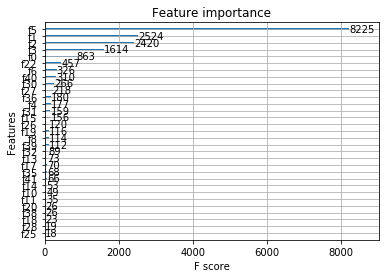

In [140]:
from xgboost import plot_importance, to_graphviz
import matplotlib.pyplot as plt


# plot feature importance
plot_importance(model)
#to_graphviz(model)
plt.show()

In [132]:
X = df.loc[:,quant_cols]
X = X.loc[:,['Age','Net_Annual_Income','Years_At_Residence','Years_At_Business']]
X.head()

,Age,Net_Annual_Income,Years_At_Residence,Years_At_Business
0,42.483231,36.0,1,1.0
1,45.552361,18.0,12,2.0
2,46.475017,36.0,10,1.0
3,37.401780,36.0,3,1.0
4,66.370979,36.0,1,1.0


accuracy:0.9426870115370302, 1-mean_Y:0.9270561965016747, precision:1.0, recall:0.21428571428571427


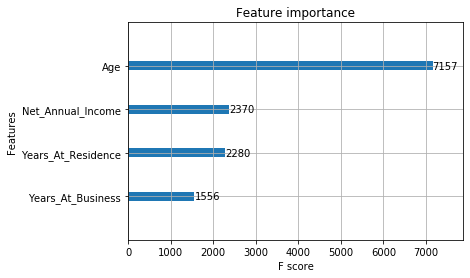

In [134]:
model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=10, reg_alpha=0.6)
model.fit(X, Y)
Y_pred = model.predict(X)
predictions = [round(value) for value in Y_pred]

accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
print(f'accuracy:{accuracy}, 1-mean_Y:{1-np.average(Y)}, precision:{precision}, recall:{recall}')

# plot feature importance
plot_importance(model)
#to_graphviz(model)
plt.show()